In [1]:
# At the beginning of your script or notebook
# %load_ext autoreload
# %autoreload 2

import os
import random
from IPython.display import HTML, display

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Third-party library imports
import torch
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split

# Local imports
from src import *
from src.probing import *
from src.visualization import _combine_html_contents, _light_mode

probes_folder = "./probe_weights_comp_only"

Triton not installed, using eager implementation of SAE decoder.


In [2]:
model_type = "llama3"

if model_type == "llama3":
    encoder = EleutherSparseAutoencoder.load_llama3_sae(12, instruct=True)
    jailbreaks_dataset = load_dataset("Mechanistic-Anomaly-Detection/llama3-jailbreaks")
elif model_type == "gemma2":
    encoder = DeepmindSparseAutoencoder.load_gemma2_sae(0, 11)
    jailbreak_dataset = load_dataset("Mechanistic-Anomaly-Detection/gemma2-jailbreaks")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
def sample_examples_from_datasets(
    datasets, proportions, total_examples=3000, only_prompts=False
):
    # This function samples examples from multiple datasets, ensuring that the final list has the desired proportions
    # of examples from each dataset. The final list is shuffled.

    # Ensure the proportions sum to 1
    if len(datasets) != len(proportions):
        raise ValueError("Number of datasets must match number of proportions")

    if abs(sum(proportions) - 1) > 1e-6:
        raise ValueError("Proportions must sum to 1")

    examples = []
    np.random.seed(42)
    for dataset, proportion in zip(datasets, proportions):
        n_samples = int(total_examples * proportion)

        # Ensure we don't try to sample more examples than available
        sampled_indices = np.random.choice(len(dataset), size=n_samples, replace=True)
        sampled = dataset.select(sampled_indices)

        if only_prompts:
            examples.extend([item["prompt"] for item in sampled])
        else:
            examples.extend(
                [f"{item['prompt']} {item['completion']}" for item in sampled]
            )

    # Shuffle the final list to mix examples from different datasets
    random.Random(42).shuffle(examples)

    return examples


forget_examples_train = sample_examples_from_datasets(
    [jailbreaks_dataset["circuit_breakers_train"]], [1.0]
)

retain_examples_train = sample_examples_from_datasets(
    [jailbreaks_dataset["xstest"], jailbreaks_dataset["benign_instructions_train"]],
    [0.15, 0.85],
)

# Also get examples with just the prompts
forget_examples_train_prompts = sample_examples_from_datasets(
    [jailbreaks_dataset["circuit_breakers_train"]], [1.0], only_prompts=True
)

retain_examples_train_prompts = sample_examples_from_datasets(
    [jailbreaks_dataset["xstest"], jailbreaks_dataset["benign_instructions_train"]],
    [0.15, 0.85],
    only_prompts=True,
)

### Train Probes

In [4]:
file_name = os.path.join(probes_folder, f"{model_type}_linear_probes.pt")

if os.path.exists(file_name):
    linear_probes = load_probes(file_name)
else:
    linear_probes = train_linear_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :1500
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :1500
        ],  # retain examples are now negative
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
        only_return_on_tokens_between=[78191, 128009],
    )
    save_probes(linear_probes, file_name)

/nas/ucb/abhay/sae_experiments/src/probing.py:829: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(load_path)


In [5]:
file_name = os.path.join(probes_folder, f"{model_type}_mlp_probes.pt")

if os.path.exists(file_name):
    mlp_probes = load_probes(file_name)
else:
    mlp_probes = train_nonlinear_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :1500
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :1500
        ],  # retain examples are now negative
        d_mlp=64,
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
    )
    save_probes(mlp_probes, file_name)

In [6]:
file_name = os.path.join(probes_folder, f"{model_type}_attention_probes.pt")

if os.path.exists(file_name):
    attention_probes = load_probes(file_name)
else:
    attention_probes = train_attention_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :1500
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :1500
        ],  # retain examples are now negative
        d_proj=64,
        nhead=8,
        sliding_window=16,
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
    )
    save_probes(attention_probes, file_name)

In [7]:
file_name = os.path.join(probes_folder, f"{model_type}_mean_diff_probes.pt")

if os.path.exists(file_name):
    mean_diff_probes = load_probes(file_name)
else:
    # Compute the steering vectors
    results = compute_steering_vector(
        encoder=encoder,
        positive_examples=forget_examples_train_prompts[:500],
        negative_examples=retain_examples_train_prompts[:500],
        layers=[4, 8, 10, 12, 16, 20, 24],
        position_aggregation="last",
        method="mean_diff",
    )

    # Construct the probes and finetune for callibration
    mean_diff_probes = {
        layer: DirectionalProbe(results[layer]["steering_vector"]) for layer in results
    }
    train_probe(
        encoder=encoder,
        positive_examples=forget_examples_train[
            :1500
        ],  # forget examples are now positive
        negative_examples=retain_examples_train[
            :1500
        ],  # retain examples are now negative
        create_probe_fn=None,
        layers=[4, 8, 10, 12, 16, 20, 24],  # train for all layers
        use_parallelism=True,
        lr=2e-3,
        max_length=1024,  # adjust this value as needed
        n_epochs=50,
        batch_size=8,
        n_grad_accum=4,
        device="cuda",
        cache_activations_save_path=os.path.join(
            probes_folder, f"{model_type}_res_stream_acts"
        ),
        pretrained_probes=mean_diff_probes,
    )

    save_probes(mean_diff_probes, file_name)

file_name = os.path.join(probes_folder, f"{model_type}_lora_linear_probes.pt")
lora_linear_probes = load_probes(file_name)

### Generate Evaluation Plots

In [8]:
def load_or_create_annotated_dataset(
    probes_folder,
    file_name,
    probes,
    encoder,
    jailbreaks_dataset,
    model_adapter_path=None,
):
    annotations_folder_name = os.path.join(probes_folder, file_name)

    if os.path.exists(annotations_folder_name):
        with open(annotations_folder_name, "r") as f:
            return json.load(f)
    else:
        datasets = [
            "harmful_gcg",
            "harmful_pair",
            "harmful_autodan",
            "harmful_human_mt",
            "harmful_msj",
            "harmful_prefill",
            "benign_instructions_test",
            "circuit_breakers_test",
            "or_bench_test",
            "mt_bench",
            "wildchat",
        ]

        kwargs = {"max_length": 8192, "batch_size": 16}

        if model_adapter_path:
            kwargs["model_adapter_path"] = model_adapter_path

        scores_dict = get_annotated_dataset(
            probes, encoder, jailbreaks_dataset, datasets, **kwargs
        )

        with open(annotations_folder_name, "w") as f:
            json.dump(scores_dict, f)

        return scores_dict


linear_scores_dict = load_or_create_annotated_dataset(
    probes_folder,
    "llama3_linear_probes_annotation_dataset.json",
    linear_probes,
    encoder,
    jailbreaks_dataset,
)

mlp_scores_dict = load_or_create_annotated_dataset(
    probes_folder,
    "llama3_mlp_probes_annotation_dataset.json",
    mlp_probes,
    encoder,
    jailbreaks_dataset,
)

attention_scores_dict = load_or_create_annotated_dataset(
    probes_folder,
    "llama3_attention_probes_annotation_dataset.json",
    attention_probes,
    encoder,
    jailbreaks_dataset,
)

mean_diff_scores_dict = load_or_create_annotated_dataset(
    probes_folder,
    "llama3_mean_diff_probes_annotation_dataset.json",
    mean_diff_probes,
    encoder,
    jailbreaks_dataset,
)

lora_linear_scores_dict = load_or_create_annotated_dataset(
    probes_folder,
    "llama3_lora_linear_probes_annotation_dataset.json",
    lora_linear_probes,
    encoder,
    jailbreaks_dataset,
    model_adapter_path="llama3_lora_linear_model",
)

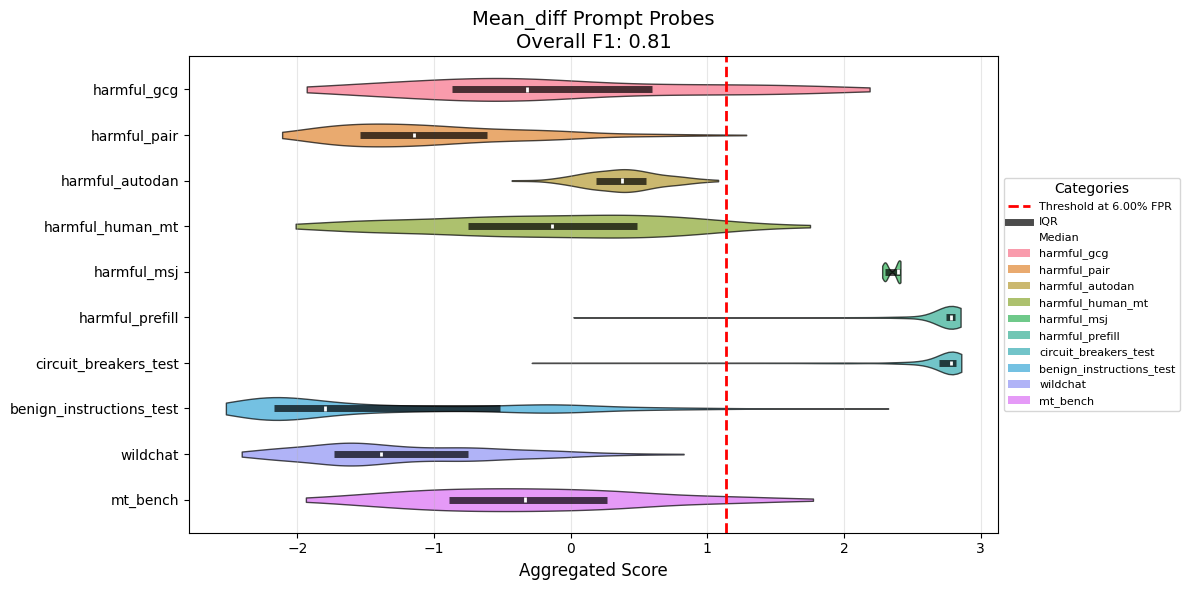

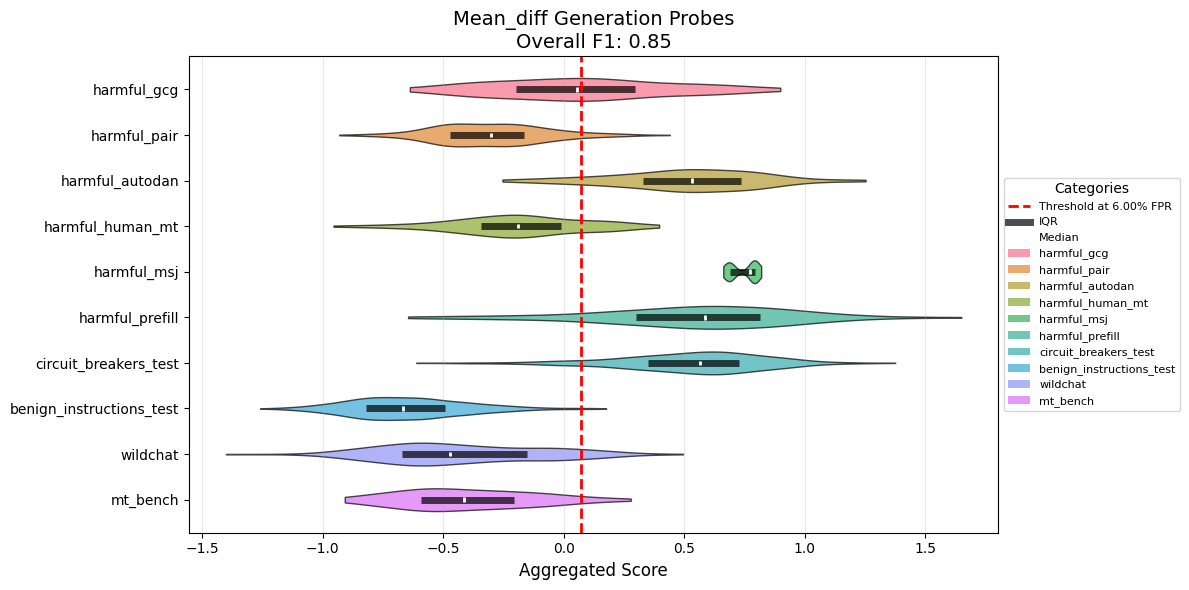

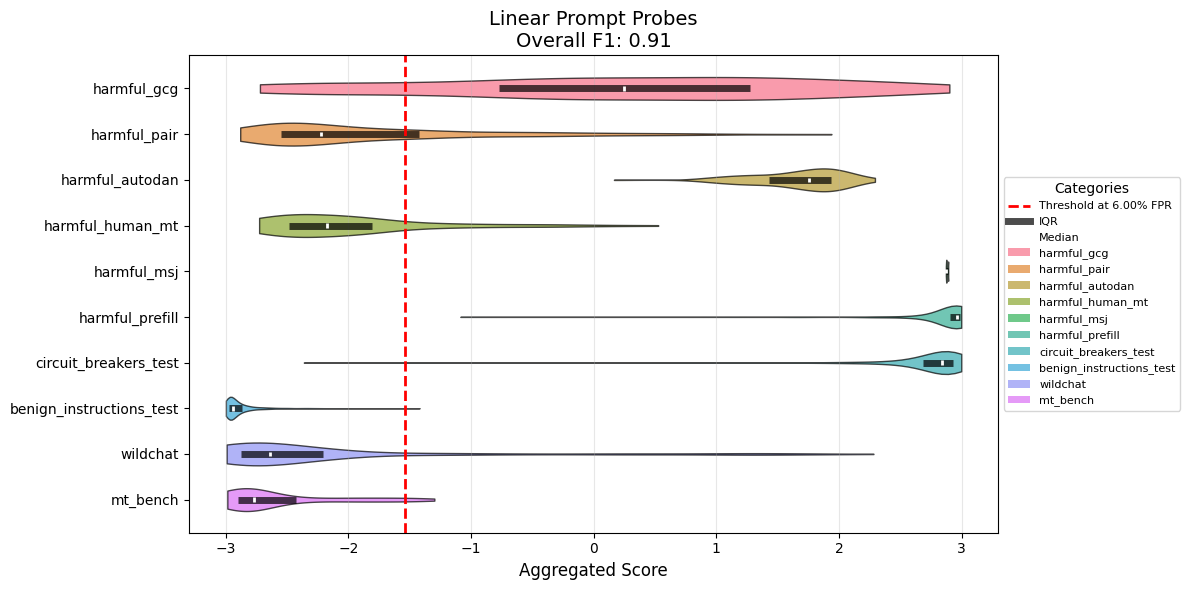

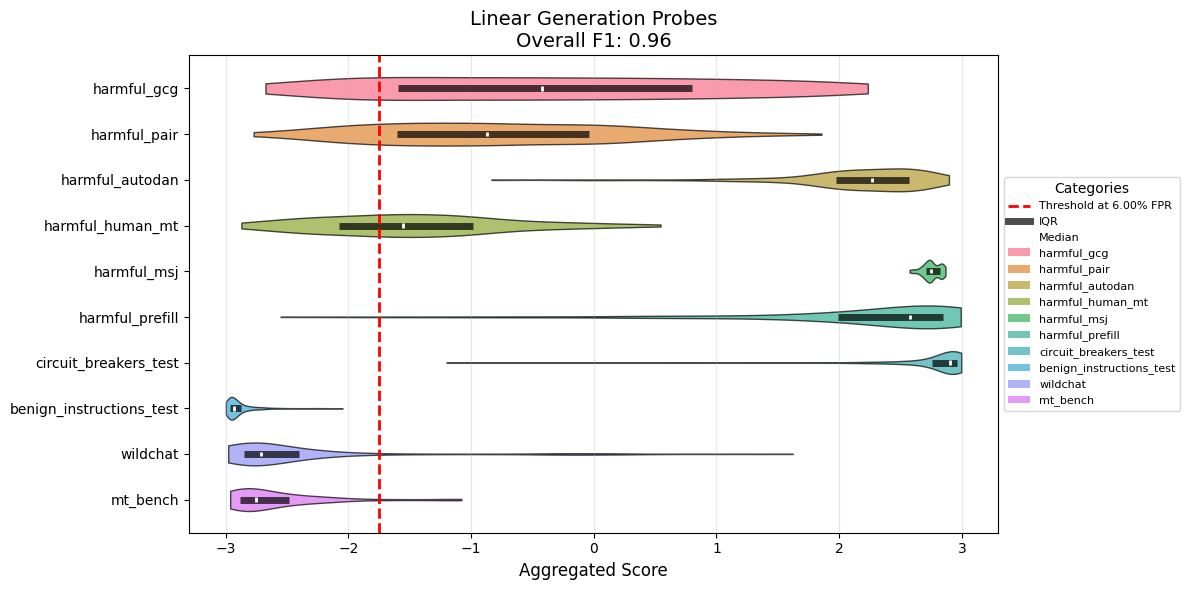

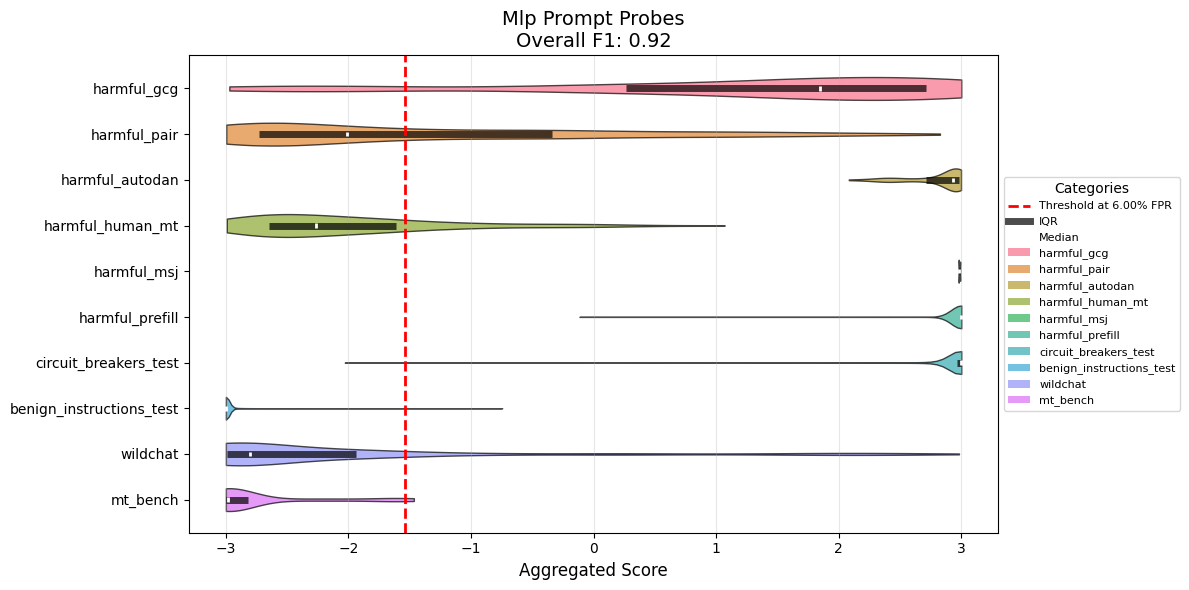

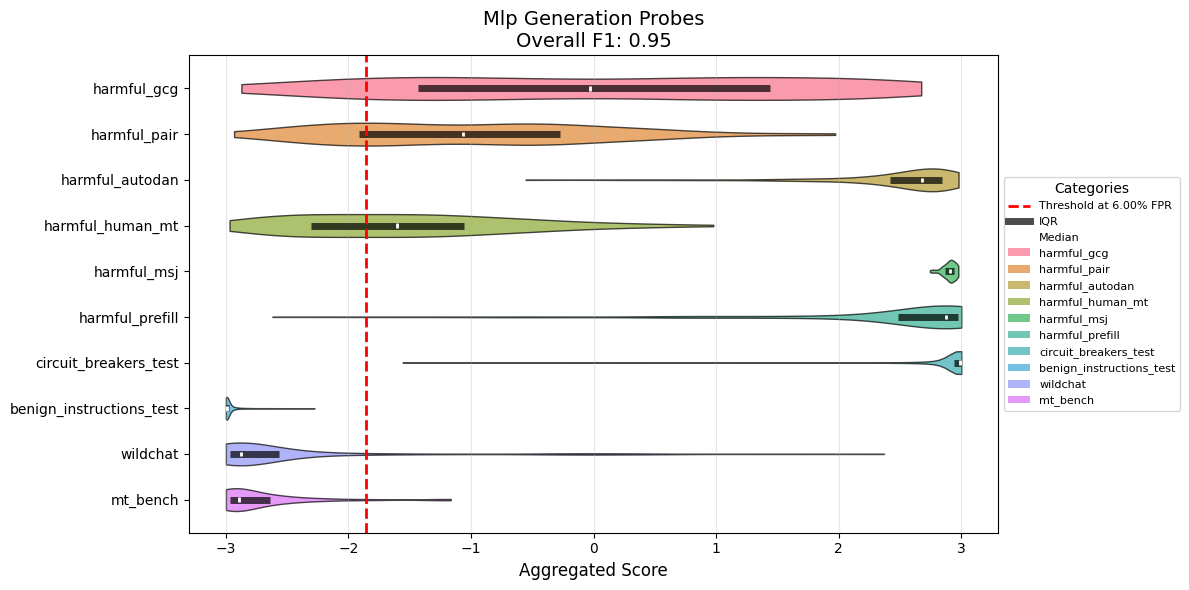

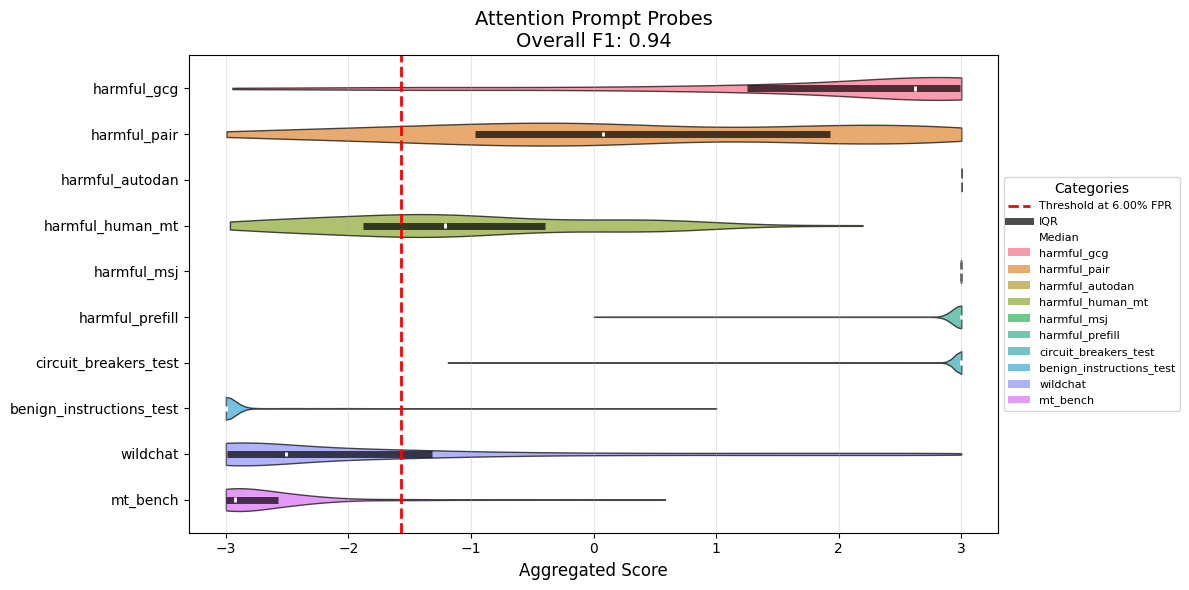

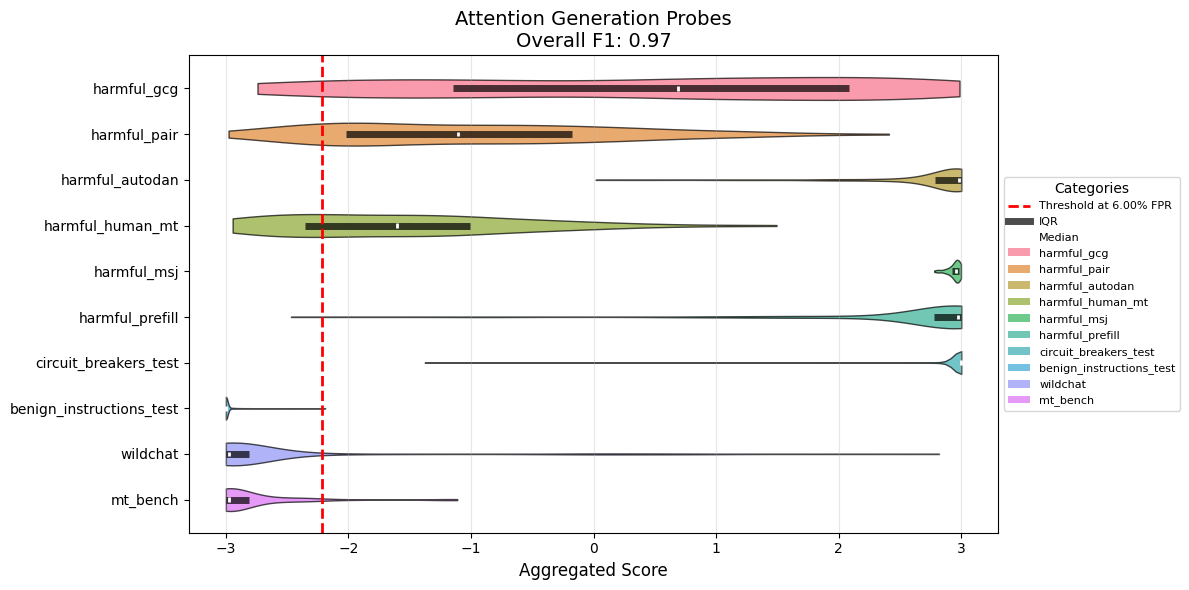

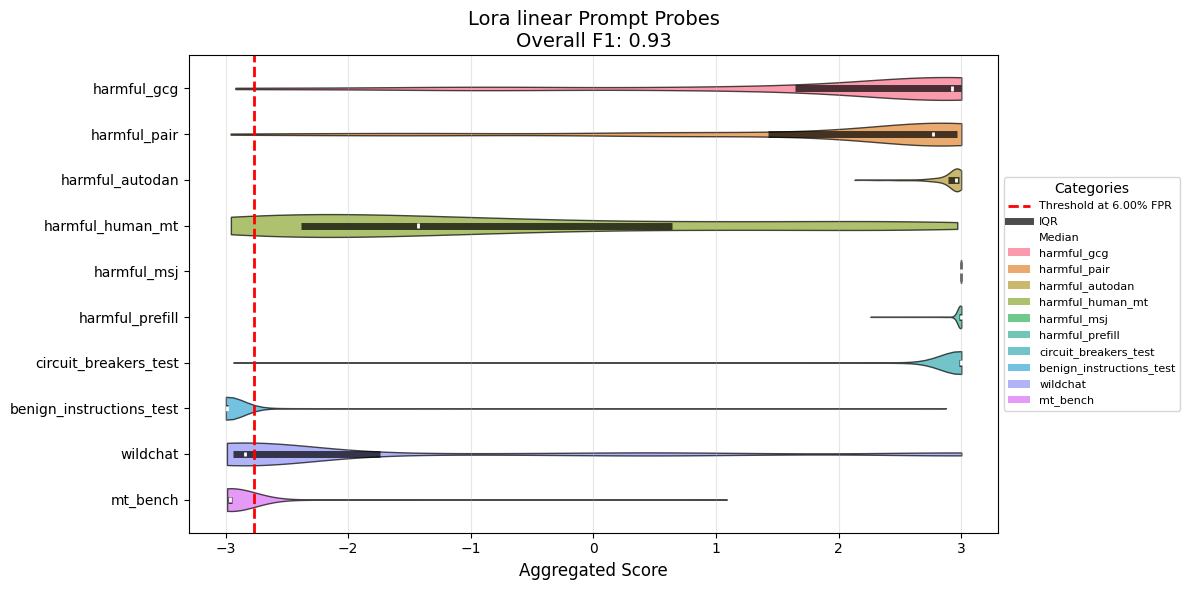

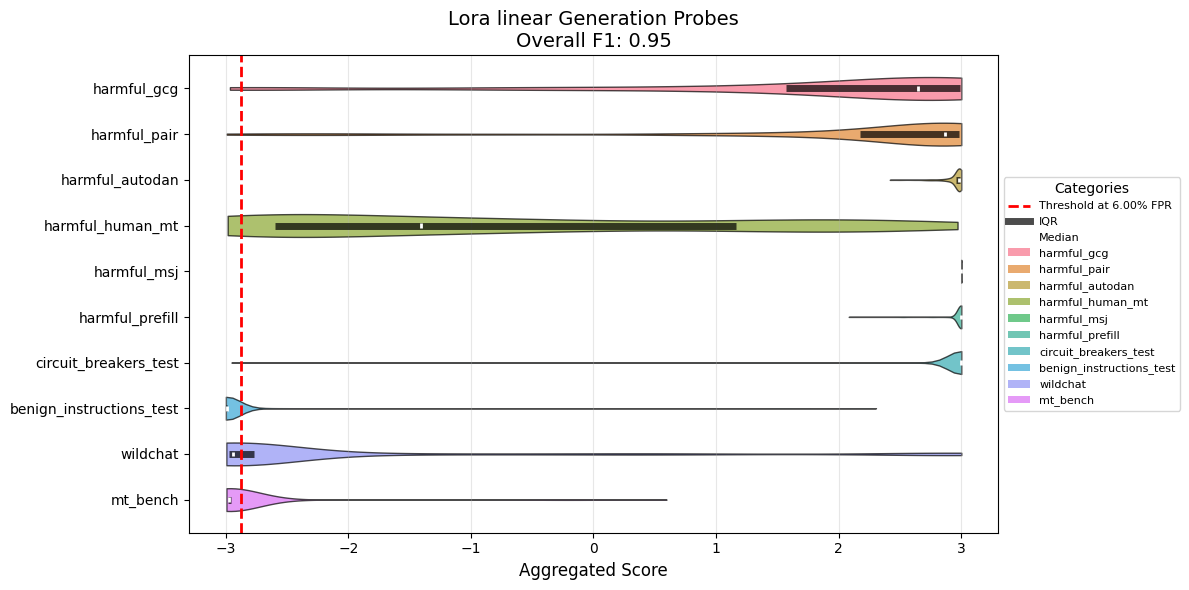

In [9]:
def get_per_split_scores(scores_dict, title):
    def check_start(index, token, tokens):
        if index < 1 or index >= len(tokens) - 1:
            return False
        return tokens[index + 1] == "\n\n" and tokens[index - 1] == "assistant"

    def input_detection(index, token, tokens):
        if index < 3 or index >= len(tokens) - 1:
            return False
        return tokens[index - 1] == "\n\n" and tokens[index - 3] == "assistant"

    def generation_detection(index, token, tokens):
        return token == "<|eot_id|>"

    prompt_scores_dict = remove_scores_between_tokens(
        scores_dict, [check_start, input_detection]
    )

    generation_scores_dict = remove_scores_between_tokens(
        scores_dict, [check_start, generation_detection]
    )

    (
        prompt_data,
        prompt_labels,
        prompt_threshold,
        prompt_f1_score,
        prompt_per_split_scores,
    ) = generate_score_plots(
        all_split_scores=prompt_scores_dict,
        positive_splits=[
            "harmful_gcg",
            "harmful_pair",
            "harmful_autodan",
            "harmful_human_mt",
            "harmful_msj",
            "harmful_prefill",
            "circuit_breakers_test",
        ],
        negative_splits=[
            "benign_instructions_test",
            "wildchat",
        ],  # "or_bench_test", ],
        heldout_splits=["mt_bench"],
        layers=[4, 8, 12, 16, 20, 24],
        cross_token_aggregation="mean",
        cross_layer_aggregation="mean",
        title=f"{title.capitalize()} Prompt Probes",
        false_positive_rate=0.06,
    )

    (
        generation_data,
        generation_labels,
        generation_threshold,
        generation_f1_score,
        generation_per_split_scores,
    ) = generate_score_plots(
        all_split_scores=generation_scores_dict,
        positive_splits=[
            "harmful_gcg",
            "harmful_pair",
            "harmful_autodan",
            "harmful_human_mt",
            "harmful_msj",
            "harmful_prefill",
            "circuit_breakers_test",
        ],
        negative_splits=[
            "benign_instructions_test",
            "wildchat",
        ],  # "or_bench_test", ],
        heldout_splits=["mt_bench"],
        layers=[4, 8, 12, 16, 20, 24],
        cross_token_aggregation="mean",
        cross_layer_aggregation="mean",
        title=f"{title.capitalize()} Generation Probes",
        false_positive_rate=0.06,
    )

    return prompt_per_split_scores, generation_per_split_scores


mean_diff_prompt_per_split_scores, mean_diff_generation_per_split_scores = (
    get_per_split_scores(mean_diff_scores_dict, "mean_diff")
)
linear_prompt_per_split_scores, linear_generation_per_split_scores = (
    get_per_split_scores(linear_scores_dict, "linear")
)
mlp_prompt_per_split_scores, mlp_generation_per_split_scores = get_per_split_scores(
    mlp_scores_dict, "mlp"
)
attention_prompt_per_split_scores, attention_generation_per_split_scores = (
    get_per_split_scores(attention_scores_dict, "attention")
)
lora_linear_prompt_per_split_scores, lora_linear_generation_per_split_scores = (
    get_per_split_scores(lora_linear_scores_dict, "lora linear")
)

### Final Results Table

In [56]:
import pandas as pd
import numpy as np

# Create dictionaries for each probe type and task
data = {
    "Mean Diff": {
        "Instruction": mean_diff_prompt_per_split_scores,
        "Generation": mean_diff_generation_per_split_scores,
    },
    "Linear": {
        "Instruction": linear_prompt_per_split_scores,
        "Generation": linear_generation_per_split_scores,
    },
    "MLP": {
        "Instruction": mlp_prompt_per_split_scores,
        "Generation": mlp_generation_per_split_scores,
    },
    "Attention": {
        "Instruction": attention_prompt_per_split_scores,
        "Generation": attention_generation_per_split_scores,
    },
    "LoRA + Linear": {
        "Instruction": lora_linear_prompt_per_split_scores,
        "Generation": lora_linear_generation_per_split_scores,
    },
}

# Define column order
jailbreak_columns = [
    "GCG",
    "PAIR",
    "AutoDAN",
    "Human MT",
    "MSJ",
    "Prefill",
    "Circuit Breakers",
]
benign_columns = ["Benign Instructions", "WildChat", "MT-Bench*"]

# Create MultiIndex for columns
column_tuples = (
    [("Jailbreak", col) for col in jailbreak_columns]
    + [("Jailbreak", "Average")]
    + [("Benign", col) for col in benign_columns]
    + [("Benign", "Average")]
)
columns = pd.MultiIndex.from_tuples(column_tuples)

# Create MultiIndex for rows
index = pd.MultiIndex.from_product([data.keys(), ["Instruction", "Generation"]])

# Create empty DataFrame
df = pd.DataFrame(index=index, columns=columns)

# Fill DataFrame
for probe, tasks in data.items():
    for task, scores in tasks.items():
        for col in jailbreak_columns + benign_columns:
            col_name = col[:-1] if col.endswith("*") else col
            original_col = {
                "GCG": "harmful_gcg",
                "PAIR": "harmful_pair",
                "AutoDAN": "harmful_autodan",
                "Human MT": "harmful_human_mt",
                "MSJ": "harmful_msj",
                "Prefill": "harmful_prefill",
                "Circuit Breakers": "circuit_breakers_test",
                "Benign Instructions": "benign_instructions_test",
                "WildChat": "wildchat",
                "MT-Bench*": "mt_bench",
            }[col]
            if original_col in scores:
                df.loc[
                    (probe, task),
                    ("Jailbreak" if col in jailbreak_columns else "Benign", col),
                ] = (
                    scores[original_col] * 100
                )

# Calculate averages
df[("Jailbreak", "Average")] = df["Jailbreak"].mean(axis=1)
df[("Benign", "Average")] = df["Benign"].mean(axis=1)

# Format numbers
df = df.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else "")

# Display the table
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
print(df.to_string())

                          Jailbreak                                                                               Benign                           
                                GCG   PAIR AutoDAN Human MT     MSJ Prefill Circuit Breakers Average Benign Instructions WildChat MT-Bench* Average
Mean Diff     Instruction     16.48   0.38    0.00     2.33  100.00   98.98            98.70   45.27               99.30   100.00     94.94   98.08
              Generation      47.25   6.06   90.26    18.60  100.00   87.82            91.90   63.13               99.20    91.29     94.94   95.14
Linear        Instruction     84.62  28.79  100.00    17.44  100.00  100.00            99.70   75.79               99.90    85.27     94.94   93.37
              Generation      79.12  79.92  100.00    62.79  100.00   98.48           100.00   88.62              100.00    89.42     94.94   94.79
MLP           Instruction     85.71  41.67  100.00    23.26  100.00  100.00            99.90   78.65            

/tmp/ipykernel_3016261/4086646628.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: f'{x:.2f}' if pd.notnull(x) else '')


In [58]:
df

Jailbreak                                          \
                                GCG   PAIR AutoDAN Human MT     MSJ Prefill   
Mean Diff     Instruction     16.48   0.38    0.00     2.33  100.00   98.98   
              Generation      47.25   6.06   90.26    18.60  100.00   87.82   
Linear        Instruction     84.62  28.79  100.00    17.44  100.00  100.00   
              Generation      79.12  79.92  100.00    62.79  100.00   98.48   
MLP           Instruction     85.71  41.67  100.00    23.26  100.00  100.00   
              Generation      85.71  73.11  100.00    58.14  100.00   98.98   
Attention     Instruction     94.51  83.71  100.00    61.63  100.00  100.00   
              Generation      91.21  83.71  100.00    68.60  100.00   99.49   
LoRA + Linear Instruction     96.70  98.11  100.00    83.72  100.00  100.00   
              Generation      95.60  98.48  100.00    90.70  100.00  100.00   

                                                                Benign  \
                          Circuit Breakers Average Benign Instructions   
Mean Diff     Instruction            98.70   45.27               99.30   
              Generation             91.90   63.13               99.20   
Linear        Instruction            99.70   75.79               99.90   
              Generation            100.00   88.62              100.00   
MLP           Instruction            99.90   78.65               99.80   
              Generation            100.00   87.99              100.00   
Attention     Instruction           100.00   91.41               99.00   
              Generation            100.00   91.86               99.90   
LoRA + Linear Instruction            99.80   96.90               96.10   
              Generation             99.90   97.81               97.10   

                                                      
                          WildChat MT-Bench* Average  
Mean Diff     Instruction   100.00     94.94   98.08  
              Generation     91.29     94.94   95.14  
Linear        Instruction    85.27     94.94   93.37  
              Generation     89.42     94.94   94.79  
MLP           Instruction    82.16     94.94   92.30  
              Generation     88.38     94.94   94.44  
Attention     Instruction    71.16     94.94   88.37  
              Generation     89.21     94.94   94.68  
LoRA + Linear Instruction    56.02     94.94   82.35  
              Generation     70.33     94.94   87.46